# Mortality Prediction in MIMIC-III with ConvNets

In [ ]:
%tensorflow_version 1.x
import numpy as np
from scipy import stats
np.random.seed(1)
from tensorflow import set_random_seed, py_func, double
set_random_seed(1)

import itertools
import os

from keras import layers, regularizers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv1D
from keras.layers import AveragePooling2D, MaxPooling2D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping


import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.utils import resample

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# https://pypi.python.org/pypi/pydot
#!apt-get -qq install -y graphviz && pip install -q pydot
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model


print(K.tensorflow_backend._get_available_gpus())

%matplotlib inline

TensorFlow 1.x selected.


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


** First some styling **

In [ ]:
plt.style.use('ggplot')
palette = plt.get_cmap('tab10')

** Define some utility functions **

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',filename=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    plt.gca().grid(False)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    
def plot_roc_curve(ground_truth, predictions, filename=None):
    fpr, tpr, thr = roc_curve(y_true=ground_truth, y_score=predictions, drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(15,10))
    lw = 2
    plt.plot(fpr, tpr,
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    return fpr, tpr, thr

def cross_validation_plot_roc_curve(ground_truth, predictions, filename=None):
    plt.figure(figsize=(15,10))
    i = 0
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for g, p in zip(ground_truth, predictions):
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_true = g, y_score = p, drop_intermediate=False)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.4f)' % (i, roc_auc))
        i += 1
    
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    plt.title('Receiver operating characteristic curve')
    plt.legend(loc="lower right")
    if filename:
        plt.savefig(filename, dpi=500)
    plt.show()
    #return mean_fpr, mean_tpr
    
def print_classification_report(ground_truth, predictions):
    print(classification_report(ground_truth, predictions, target_names=['die'], labels=[1]))

** Some important values **

In [ ]:
inputs_filename = 'MIMICIII_sapsii_dataset_inputs.pickle'
outputs_filename = 'MIMICIII_sapsii_dataset_mortality_labels.pickle'
split_data = False
model_factories = dict()

## Loading the dataset
Now we will load the dataset from the pickled dataframes

In [ ]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
#file_id = '1KafdxsKb2c-qunWNhQKNDMyfwuUOCqXF'
#downloaded_1 = drive.CreateFile({'id': file_id})
#downloaded_1.GetContentFile(inputs_filename)


#file_id = '1bF28AYLFipGf98ooc-pTtrapiT18Xcms'
#downloaded_2 = drive.CreateFile({'id': file_id})
#downloaded_2.GetContentFile(outputs_filename)

!wget -O MIMICIII_sapsii_dataset_inputs.pickle https://www.dropbox.com/s/wies5aqklli3vfr/MIMICIII_sapsii_dataset_inputs.pickle?dl=1

!wget -O MIMICIII_sapsii_dataset_mortality_labels.pickle https://www.dropbox.com/s/dtt521s7y1m1w7f/MIMICIII_sapsii_dataset_mortality_labels.pickle?dl=1



--2020-05-20 07:53:02--  https://www.dropbox.com/s/wies5aqklli3vfr/MIMICIII_sapsii_dataset_inputs.pickle?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/wies5aqklli3vfr/MIMICIII_sapsii_dataset_inputs.pickle [following]
--2020-05-20 07:53:03--  https://www.dropbox.com/s/dl/wies5aqklli3vfr/MIMICIII_sapsii_dataset_inputs.pickle
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc43fefd6aec57b15500457077e5.dl.dropboxusercontent.com/cd/0/get/A4EfHz8XRVc_C0qTg3WgF5my-silKVVKjQAXnhIDkUvTInCRLTcxSMDM02JVtKv6p7bgUEaUZ8LJuNfQaFf1USFTduICUkEixfsuKRSfP_pnqSmI0exg8aDCBivOcEI-L-I/file?dl=1# [following]
--2020-05-20 07:53:03--  https://uc43fefd6aec57b15500457077e5.dl.dropboxusercontent.com/cd/0/get/A4EfHz8XRVc_C0qTg3WgF5my-silKVVKjQ

In [ ]:
input_dataframe = pd.read_pickle(inputs_filename);
labels_dataframe = pd.read_pickle(outputs_filename)

**A sanity check:**

In [ ]:
id2 = labels_dataframe['subject_id'].values
id1 = input_dataframe.index.levels[0].values
print(np.setdiff1d(id2,id1))
labels_dataframe.head(10)

[]


,subject_id,mort_icu
0,3,0
842,6,0
1124,9,1
1570,12,0
1965,13,0
2661,17,0
2956,21,0
3274,25,0
3587,26,0
3779,31,1


## Imputation

In [ ]:

#For urine is it better to impute mean, or include an imputation mask
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSEyes'].fillna(method='ffill', axis=1)#.fillna(value=4) 

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'] = \
input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSMotor'].fillna(method='ffill', axis=1)#.fillna(value=6)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'GCSVerbal'].fillna(method='ffill', axis=1)#.fillna(value=5)

#input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'] = \
#    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'URINE OUTPUT'].fillna(value=0)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'FiO2'].fillna(method='ffill', axis=1).fillna(value=0.2)

input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'] = \
    input_dataframe[input_dataframe.index.get_level_values('measurement_name') == 'PO2'].fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

#Now the rest of NAs are filled
#NOTE: Some NAs will remain, specifically if there is not even one measurement, all values for that particular variable will still be NAs
input_dataframe = input_dataframe.fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


In [ ]:
cv = StratifiedKFold(n_splits=5, random_state=42)
cv_idx = list(cv.split(X=np.zeros(labels_dataframe.shape[0]), y=labels_dataframe['mort_icu'].values))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [ ]:
#input_dataframe = input_dataframe.drop(index=['BILIRUBIN', 'LYMPHOMA'], level=1)
#input_dataframe.index.remove_unused_levels()

In [ ]:
input_dataframe.loc[np.array([0,1,2])]
print(input_dataframe.loc[cv_idx[0][0]].shape[0]/22)
print(cv_idx[0][0].shape[0])
#cv_idx[0][0]

7615.0
17930


In [ ]:
print(input_dataframe.index.levels[0].values.max())

99995


In [ ]:
print(cv_idx[0][0])
input_dataframe.index.levels[0][cv_idx[0][0]]

[ 4433  4466  4474 ... 22410 22411 22412]


Int64Index([10200, 10288, 10305, 10314, 10327, 10332, 10334, 10335, 10337,
            10338,
            ...
            99938, 99939, 99944, 99955, 99957, 99973, 99982, 99985, 99991,
            99995],
           dtype='int64', name='subject_id', length=17930)

In [ ]:
#input_dataframe.iloc[cv_idx[0][0]]
#input_dataframe.iloc[[4474],:]
#label = input_dataframe.index.levels[0][4466]
#input_dataframe.iloc[input_dataframe.index.get_loc(label)]
labels = input_dataframe.index.levels[0][cv_idx[0][0]]
input_dataframe.iloc[input_dataframe.index.get_locs([labels, slice(None)])]

measurement_hour                   0.0         1.0   ...        46.0        47.0
subject_id measurement_name                          ...                        
10200      AGE                73.770442   73.770442  ...   73.770442   73.770442
           AIDS                0.000000    0.000000  ...    0.000000    0.000000
           BICARBONATE        24.000000   24.000000  ...   24.000000   24.000000
           BILIRUBIN                NaN         NaN  ...         NaN         NaN
           BUN                 9.000000    9.000000  ...   12.000000   12.000000
...                                 ...         ...  ...         ...         ...
99995      SURGICAL            1.000000    1.000000  ...    1.000000    1.000000
           SYSTOLIC BP       123.333333  123.333333  ...  124.000000  136.000000
           TEMPERATURE        36.444444   36.444444  ...   36.777778   36.777778
           URINE OUTPUT      120.000000  120.000000  ...   50.000000   50.000000
           WBC                 8.200000    8.200000  ...    6.400000    6.400000

[394460 rows x 48 columns]

Save fold means and deviations to standardize later

In [ ]:
fold_mean = []
fold_std = []

for train, validation in cv_idx:
    #fold = input_dataframe.iloc[train]
    labels = input_dataframe.index.levels[0][train]
    fold = input_dataframe.iloc[input_dataframe.index.get_locs([labels, slice(None)])]
    
    mean = fold.mean(level='measurement_name').mean(axis=1)
    std = fold.std(level='measurement_name').mean(axis=1)
    #Store training fold mean and std to standardize validation folds later
    #Extra dimension is added to make broadcasted division and subtraction possible
    fold_mean.append(mean.values[:, None]) 
    fold_std.append(std.values[:, None])
    

In [ ]:
fold_std[4]

array([[1.56324850e+01],
       [1.02925452e-01],
       [4.47114832e+00],
       [4.56100154e+00],
       [2.07617132e+01],
       [1.35971064e+01],
       [3.50075047e-01],
       [2.69268229e+01],
       [1.09277921e+00],
       [1.43416151e+00],
       [1.88783321e+00],
       [1.78544078e+01],
       [1.67497867e-01],
       [2.38126811e-01],
       [6.75003343e+01],
       [5.82159214e-01],
       [4.62112588e+00],
       [4.97045363e-01],
       [2.15467791e+01],
       [7.91595869e-01],
       [1.63321071e+02],
       [8.44684756e+00]])

Now, let's shape our data properly

In [ ]:
X = input_dataframe.values.reshape([input_dataframe.index.levels[0].shape[0], len(fold_mean[0]), input_dataframe.shape[1]])
y = labels_dataframe.values

#Reshape so each physiological time series 
#becomes a channel (3D) instead of a matrix row (2D)
#X = np.swapaxes(X, 1, 2).reshape((-1, 1, input_dataframe.shape[1], input_dataframe.index.levels[1].shape[0])).astype(np.float32)
X = X.reshape((-1, 1, len(fold_mean[0]), input_dataframe.shape[1])).astype(np.float32)
y = y[:, 1]
y = y[:, None].astype(np.float32)
print("Training inputs shape: {0}".format(X.shape))
print("Training labels shape: {0}".format(y.shape))

Training inputs shape: (22413, 1, 22, 48)
Training labels shape: (22413, 1)


Next, if necessary compute the train/test splits

In [ ]:
if split_data :
    #y = y[:,1]
    #y = y[:,None]
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        stratify=y, random_state=42)
    #X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    print("Number of patients in training: {0}, number of deaths in training: {1}".format(y_train.shape[0], np.sum(y_train)))
    print("Number of patients in test: {0}, number of deaths in test: {1}".format(y_test.shape[0], np.sum(y_test)))
else:
    X_train = X
    y_train = y #Will do Cross-Validation instead

## Convnet 
Now let's define our Keras ConvNet model

In [ ]:
def create_model1(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(64, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(16, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                     name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    #Second layer
    
    #Conv
    short_term_conv = Conv2D(128, (3,1), strides = (1,1), padding = 'same',
                             name = '3h_conv2')(X)
    medium_term_conv = Conv2D(128, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv2')(X)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled2')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled2')(medium_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout2')(X)
    #BatchNorm
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(128, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-1'] = create_model1

def create_model2(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(64, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(16, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                     name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    #Second layer
    
    #Conv
    short_term_conv = Conv2D(64, (3,1), strides = (1,1), padding = 'same',
                             name = '3h_conv2')(X)
    medium_term_conv = Conv2D(64, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv2')(X)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    
    #Max pooling
    short_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled2')(short_term_conv)
    medium_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled2')(medium_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout2')(X)
    #BatchNorm
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(128, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-2'] = create_model2

def create_model3(input_shape, use_dropout = False, conv_drop_prob = 0.5, fc_drop_prob = 0.5, l2_penalty = 0.01):
    X_input = Input(input_shape, name='input')
    
    #First layer
    
    #Conv
    short_term_conv = Conv2D(16, (3,1), strides = (1,1), padding = 'same', name = '3h_conv')(X_input)
    medium_term_conv = Conv2D(16, (6,1), strides = (1,1), padding = 'same',
                              name = '6h_conv')(X_input)
    long_term_conv = Conv2D(16, (12,1), strides = (1,1), padding = 'same',
                            name = '12h_conv')(X_input)
    #extra_long_term_conv = Conv2D(64, (24,1), strides = (1,1), padding = 'same',
    #                              name = '24h_conv')(X_input)
    #ReLU
    short_term_conv = Activation('relu')(short_term_conv)
    medium_term_conv = Activation('relu')(medium_term_conv)
    long_term_conv = Activation('relu')(long_term_conv)
    #extra_long_term_conv = Activation('relu')(extra_long_term_conv)
    #
    #Max pooling
    short_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                     name = '3h_pooled')(short_term_conv)
    medium_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                      name = '6h_pooled')(medium_term_conv)
    long_term_conv = AveragePooling2D(pool_size = (1,3), padding = 'same', 
                                    name = '12h_pooled')(long_term_conv)
    #extra_long_term_conv = MaxPooling2D(pool_size = (1,3), padding = 'same',
    #                                    name = '24h_pooled')(extra_long_term_conv)
    #Concat
    X = layers.concatenate([short_term_conv, medium_term_conv, long_term_conv], axis=3)
    #Dropout
    if use_dropout:
        X = Dropout(conv_drop_prob, name = 'dropout1')(X)
    #BatchNorm
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    
    
    #Fully connected layer
    X = Flatten()(X)
    X = Dense(256, activation = 'relu', name = 'fc1', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    #Dropout
    if use_dropout:
        X = Dropout(fc_drop_prob, name = 'dropout3')(X)
    #BatchNorm
    X = BatchNormalization(axis = 1, name='bn3')(X)
    
    
    #Output softmax layer
    X = Dense(1, activation = 'sigmoid', name = 'fc2', kernel_regularizer=regularizers.l2(l2_penalty))(X)
    
    model = Model(inputs = X_input, outputs = X, name='icu_mortality_conv')
    return model

model_factories['model-3'] = create_model3

## Training


In [ ]:
validation_idx = cv_idx[4][1]

patient_index = 1
patient = X[validation_idx[patient_index]]

patient

array([[[ 20.06622 ,  20.06622 ,  20.06622 , ...,  20.06622 ,
          20.06622 ,  20.06622 ],
        [  0.      ,   0.      ,   0.      , ...,   0.      ,
           0.      ,   0.      ],
        [ 29.      ,  29.      ,  29.      , ...,  22.      ,
          22.      ,  22.      ],
        ...,
        [ 35.88889 ,  35.88889 ,  35.88889 , ...,  36.      ,
          36.      ,  36.055557],
        [220.      , 220.      , 220.      , ...,  80.      ,
          90.      ,  75.      ],
        [ 11.6     ,  11.6     ,  11.6     , ...,  16.1     ,
          16.1     ,  16.1     ]]], dtype=float32)

In [ ]:
#np.save('patient', patient)
#from google.colab import files
#files.download('/content/patient.npy')

**Let's go!**

In [ ]:
#def auroc(y_true, y_pred):
#    return py_func(lambda t, p : roc_auc_score(t, p) if np.sum(t) > 0 else 0.5, (y_true, y_pred), double)

model_func = model_factories['model-3']
batch_size = 32
epochs = 100
class_weight = {0:1, 1:10} 
use_dropout = True
conv_drop_prob = 0.45
fc_drop_prob = 0.45
l2_penalty = 0.0
folder_name = "plots/epochs_{0}_class_weight_{1}_batch_size_{2}".format(epochs, class_weight[1], 
                                                                                       batch_size)
if use_dropout:
    folder_name = folder_name + "_conv_dropout_{0}_fc_dropout_{1}".format(conv_drop_prob, fc_drop_prob) 

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    

predictions = []
predictions_training_set = []
ground_truth = []
ground_truth_training_set = []
fold_history = []

i = 0
for train, validation in cv_idx:
    print(f'Fold {i}. Positive examples in validation: {np.sum(y_train[validation])}...')
    
    ground_truth_training_set.append(y_train[train])
    ground_truth.append(y_train[validation])
    
    model = model_func((1,len(fold_mean[0]),48), use_dropout, 
                                   conv_drop_prob = conv_drop_prob, 
                                   fc_drop_prob = fc_drop_prob, 
                                   l2_penalty=l2_penalty)
    sgd = optimizers.SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=True)
    model.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    scaled_X_train = (X_train[train] - fold_mean[i])/fold_std[i] #Standardize
    scaled_X_train = np.nan_to_num(scaled_X_train) #Implicit mean imputation for remaining NaNs
    scaled_X_validation = (X_train[validation] - fold_mean[i])/fold_std[i] #Standardize using train set mean. No Leaking
    scaled_X_validation = np.nan_to_num(scaled_X_validation) #Implicit mean imputation for remaining NaNs
    
    checkpoint_cb = ModelCheckpoint(filepath=f"./{folder_name}/kfold{i}_best.hdf5", monitor='val_loss', save_best_only=True)
    fold_history.append(model.fit(x = scaled_X_train, y = y_train[train], 
                                  epochs = epochs, batch_size = batch_size, 
                                  class_weight=class_weight, 
                                  callbacks=[checkpoint_cb], validation_data=(scaled_X_validation, 
                                                                              y_train[validation])))
    
    files = [f for f in os.listdir("./{0}".format(folder_name)) if f.endswith(f"kfold{i}_best.hdf5")]
    model = load_model(f"./{folder_name}/{files[0]}")
    predictions_training_set.append(model.predict(scaled_X_train))
    predictions.append(model.predict(scaled_X_validation))
    i += 1

Fold 0. Positive examples in validation: 437.0...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 17930 samples, validate on 4483 samples
Epoch 1/100
17930/17930 [==============================] - 11s 632us/step - loss: 1.4298 - accuracy: 0.6805 - val_loss: 0.5632 - val_accuracy: 0.7562
Epoch 2/100
17930/17930 [==============================] - 5s 290us/step - loss: 1.1676 - accuracy: 0.7086 - val_loss: 0.5650 - val_accuracy: 0.6723
Epoch 3/100
17930/17930 [==============================] - 5s 285us/step - loss: 1.0575 - accuracy: 0.7152 - val_loss: 0.6135 - val_accuracy: 0.6754
Epoch 4/100
17930/17930 [==============================] - 5s 282us/step - loss: 1.0003 - accuracy: 0.7250 - val_loss: 0.6354 - val_accuracy: 0.6534
Epoch 5/100
17930/17930 [==============================] - 5s 287us/step - loss: 0.9699 - accuracy: 0.7284 - val_loss: 0.5727 -

## Debug and evaluation
Now we inspect the loss and accuracy behavior during training:

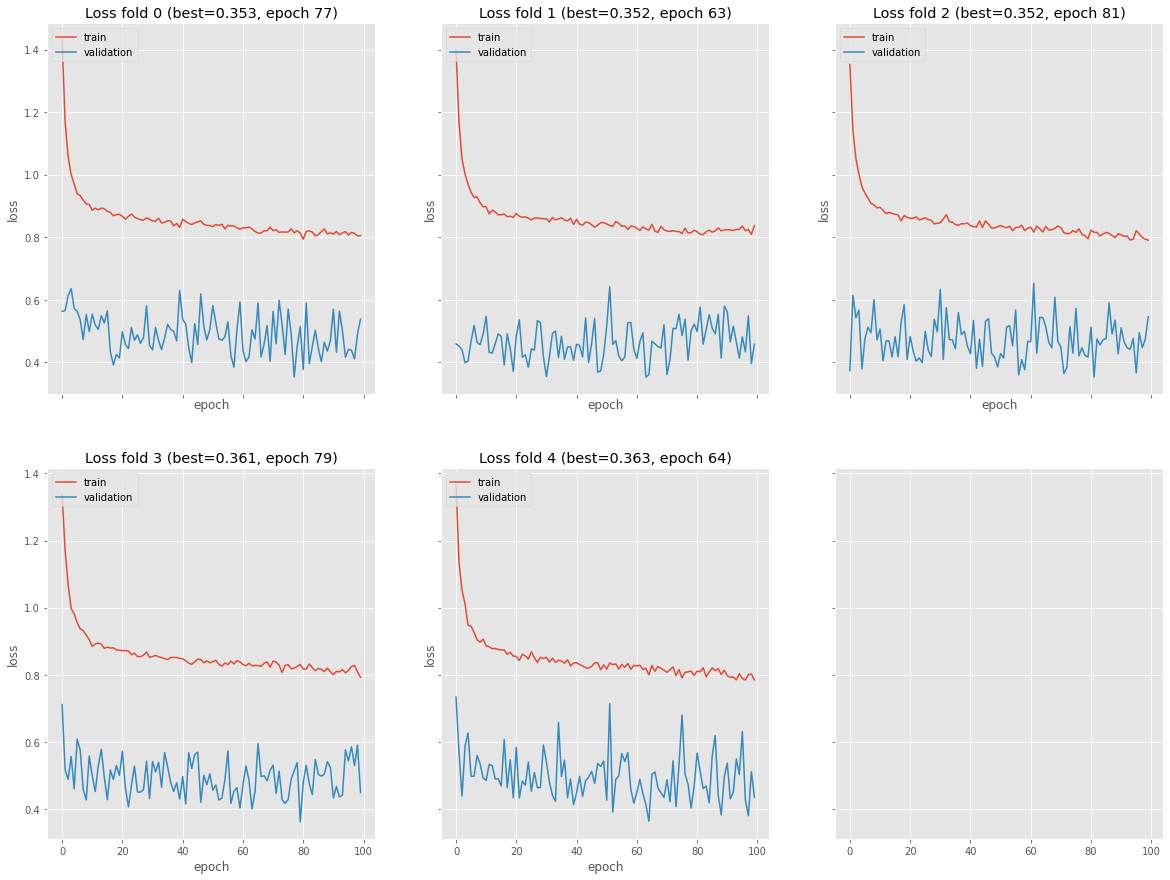

In [ ]:

fig, ax = plt.subplots(2, 3, sharex='col', sharey='row', figsize=(20,15))
for k, history in enumerate(fold_history):
    #Loss
    j = np.argmin(history.history['val_loss'])
    
    ax[int(k // 3), k % 3].plot(history.history['loss'])
    ax[int(k // 3), k % 3].plot(history.history['val_loss'])
    ax[int(k // 3), k % 3].set_title('Loss fold {0} (best={1:.3f}, epoch {2})'.format(k, history.history['val_loss'][j], j))
    ax[int(k // 3), k % 3].set_ylabel('loss')
    ax[int(k // 3), k % 3].set_xlabel('epoch')
    ax[int(k // 3), k % 3].legend(['train', 'validation'], loc='upper left')
plt.savefig('{0}/loss_history.png'.format(folder_name), dpi=500)
plt.show()

Now let's see the performance in both training and test sets:

### Training:

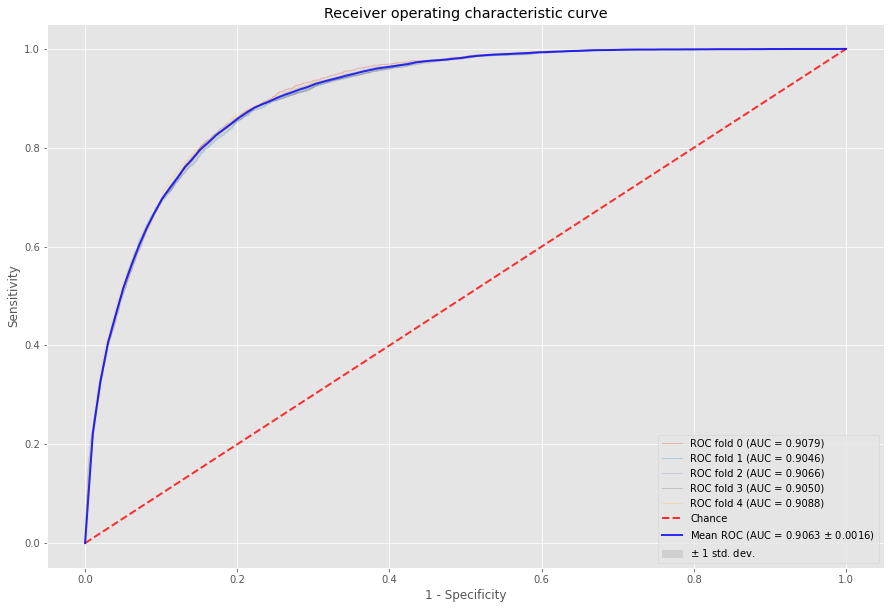

In [ ]:
cross_validation_plot_roc_curve(ground_truth_training_set, predictions_training_set,
                               filename='{0}/roc_curve_training.png'.format(folder_name))

### Validation:

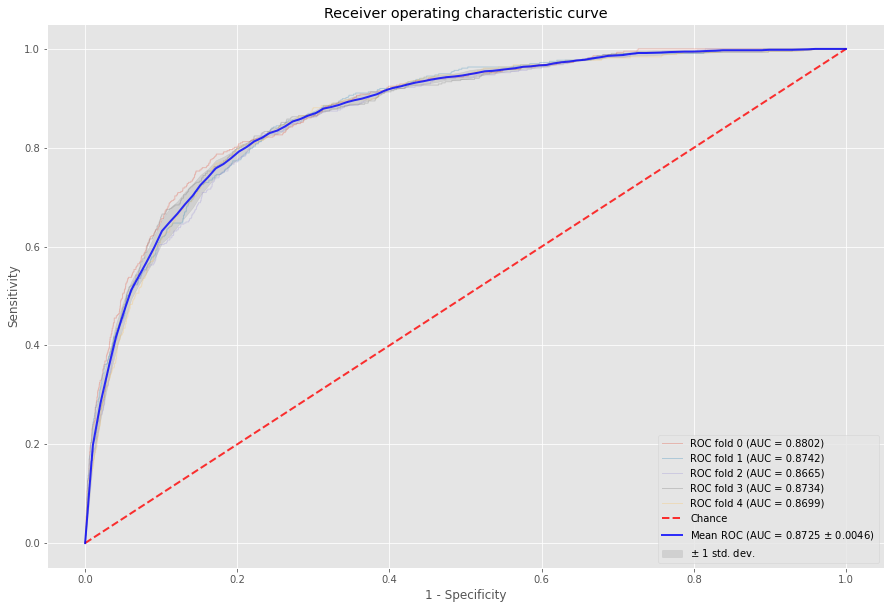

In [ ]:
cross_validation_plot_roc_curve(ground_truth, predictions, 
                                filename='{0}/roc_curve_validation.png'.format(folder_name))

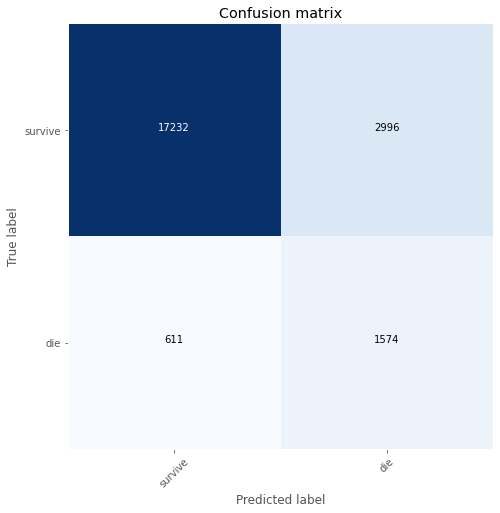

In [ ]:
cnf_matrix = [[0,0],[0,0]]
for g,p in zip(ground_truth, predictions):
    #print_classification_report(g, p)
    cnf_matrix += confusion_matrix(g, p.round())
target_names = ['survive', 'die']
plot_confusion_matrix(cnf_matrix, classes=target_names, filename='{0}/confusion_matrix.png'.format(folder_name),
                      title='Confusion matrix')

In [ ]:
with open('{0}/model_summary.txt'.format(folder_name),'w') as fh:
    model.summary(print_fn=lambda x: fh.write(x + '\n'))
model.summary()

Model: "icu_mortality_conv"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1, 22, 48)    0                                            
__________________________________________________________________________________________________
3h_conv (Conv2D)                (None, 1, 22, 16)    2320        input[0][0]                      
__________________________________________________________________________________________________
6h_conv (Conv2D)                (None, 1, 22, 16)    4624        input[0][0]                      
__________________________________________________________________________________________________
12h_conv (Conv2D)               (None, 1, 22, 16)    9232        input[0][0]                      
_________________________________________________________________________________

In [ ]:
# https://pypi.python.org/pypi/pydot
!pip install -q deeplift

import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import os

import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def visualize_patient_inputs(patient, rows, cols, size, cycle_colors=False, cmap = plt.cm.coolwarm, norm=None, colorbar_ticks=[], 
                             feature_importances = None, filename = None):
    
    fig, ax = plt.subplots(rows, cols, sharex='col', figsize=(30,20))
    for i, v in enumerate(predictor_names):
        if v in ('AIDS', 'ELECTIVE', 'METASTATIC_CANCER', 'LYMPHOMA', 'SURGICAL', 'ELECTIVE'):
            ax[int(i // 2), i % 2].set_ylim((-2, 2))
            
        ax[int(i // 2), i % 2].plot(range(48), patient[i],
                   lw=2.5, color=palette(i%10) if cycle_colors else palette(0),
                   marker='o', markersize=6)
        ax[int(i // 2), i % 2].legend([v], loc='upper left')
        if feature_importances is not None:
            if len(feature_importances.shape) == 3:
                for j in range(48):
                    ax[int(i // 2), i % 2].axvspan(j, j+1, facecolor=feature_importances[i,j], alpha=0.5)
            else:
                ax[int(i // 2), i % 2].axvspan(0, 48, facecolor=feature_importances[i], alpha=0.5)
                
    if feature_importances is not None:
        ax_cb = fig.add_axes([0.92,0.125,0.015,0.755])
        cb1 = mpl.colorbar.ColorbarBase(ax_cb, cmap=cmap, norm=norm, ticks=colorbar_ticks, orientation='vertical')
    plt.subplots_adjust(wspace=0.05)
    if filename is not None:
        plt.savefig(filename, dpi=500, bbox_inches='tight')
    plt.show()
    
# set the colormap and centre the colorbar
# http://chris35wills.github.io/matplotlib_diverging_colorbar/
class MidpointNormalize(mpl.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

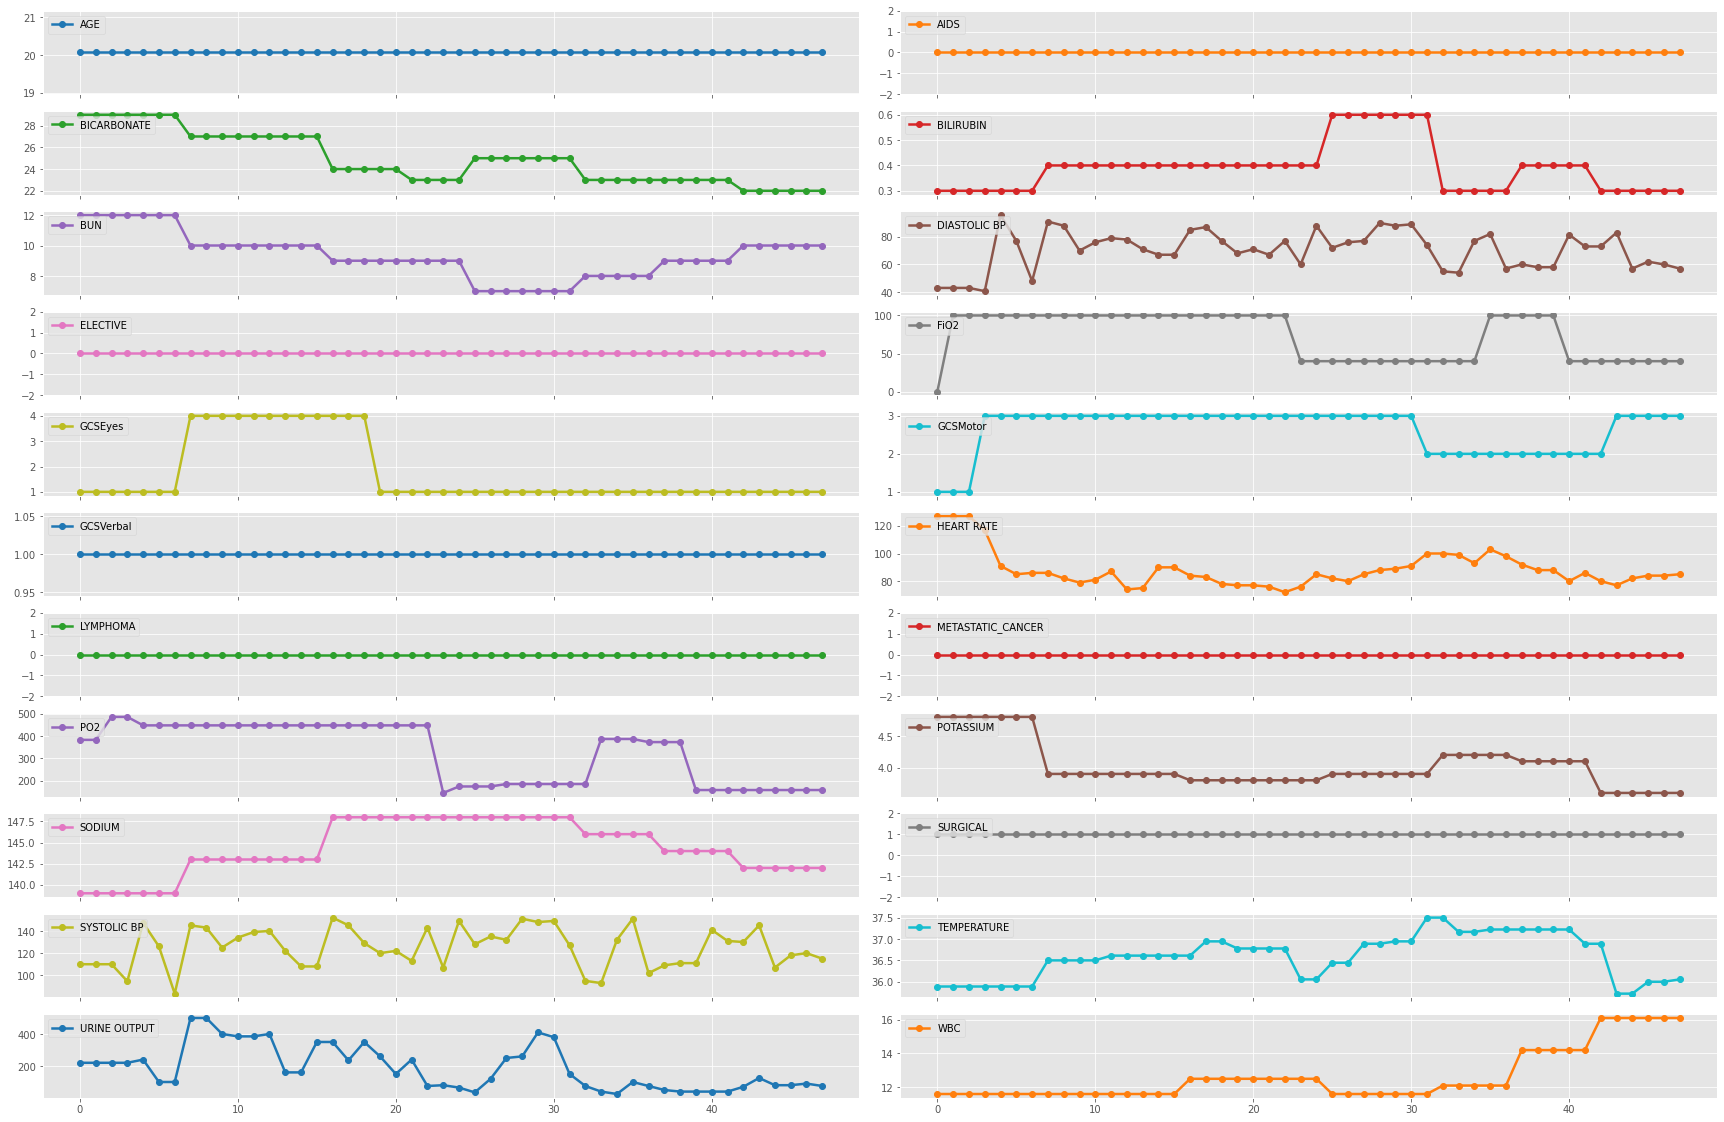

In [ ]:
if not os.path.exists('explain_model_plots'):
    os.makedirs('explain_model_plots')
    
validation_idx = cv_idx[4][1]

patient_index = 1
patient = X[validation_idx[patient_index]][0]
#patient = patient* fold_std[4] + fold_mean[4]
#mortality_prob = predictions[-len(validation_idx) + patient_index]
#print(patient)
predictor_names = input_dataframe.index.levels[1].values
visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=True, filename='explain_model_plots/patient{0}_inputs.png'.format(patient_index))

In [ ]:
deeplift_model = []
for i in range(5):
  print(f'fold{i}...')
  dm = kc.convert_model_from_saved_files(
      h5_file=f"{folder_name}/kfold{i}_best.hdf5",
                              nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)
  deeplift_model.append(dm)

fold0...
nonlinear_mxts_mode is set to: RevealCancel



/usr/local/lib/python3.6/dist-packages/deeplift/conversion/kerasapi_conversion.py:352: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  str_data = h5py.File(h5_file).attrs["model_config"]
/usr/local/lib/python3.6/dist-packages/deeplift/conversion/kerasapi_conversion.py:359: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  model_weights = h5py.File(h5_file)


Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold1...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold2...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold3...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
fold4...
nonlinear_mxts_mode is set to: RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func


In [ ]:
input_layer_name = deeplift_model[0].get_input_layer_names()[0]
deeplift_prediction_func = []
converted_model_predictions = []
for i in range(5):
  dpf = compile_func([deeplift_model[i].get_name_to_layer()[input_layer_name].get_activation_vars()],
                                           deeplift_model[i].get_name_to_layer()['fc2_0'].get_activation_vars())
  deeplift_prediction_func.append(dpf)

  
  converted_model_predictions += [deeplift.util.run_function_in_batches(
                                  input_data_list=[np.nan_to_num((X[cv_idx[i][1]]- fold_mean[i])/fold_std[i])],
                                  func=deeplift_prediction_func[i],
                                  #batch_size=200,
                                  progress_update=None)]

#print("maximum difference in predictions:",np.max(np.array(converted_model_predictions)-np.array(predictions[-len(validation_idx):-1])))
#assert np.max(np.array(converted_model_predictions)-np.array(predictions[-len(validation_idx):-1])) < 10**-5
#predictions = converted_model_predictions

TARGET LAYER SET TO preact_fc2_0



Done 0
Predicted mortality probability: [0.48394948]
Observed mortality: [1.]


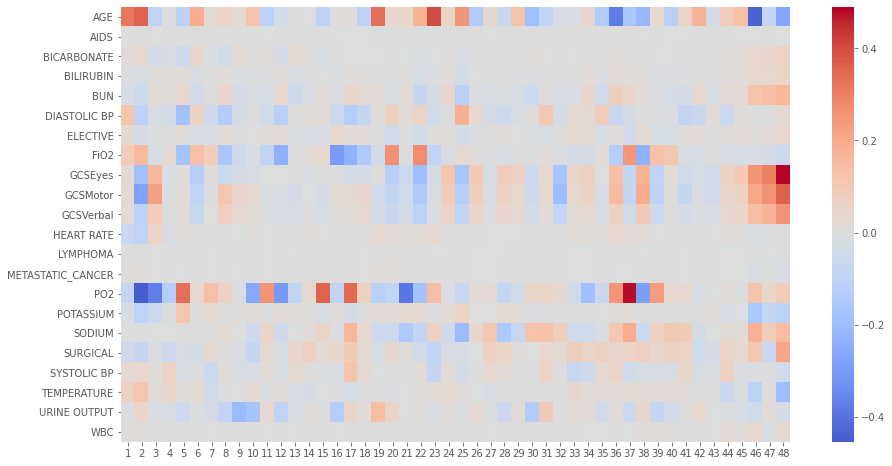

In [ ]:
#input_layer_name = deeplift_model.get_input_layer_names()[0]
importance_func = deeplift_model[4].get_target_contribs_func(
    find_scores_layer_name=input_layer_name, pre_activation_target_layer_name='preact_fc2_0')
scores = np.array(
    importance_func(task_idx=0, input_data_list=[[np.nan_to_num((X[validation_idx][patient_index] - fold_mean[4])/fold_std[4])]],
                      input_references_list=[np.zeros_like([X[validation_idx][0]])],
                      batch_size=1,progress_update=1))
print('Predicted mortality probability: {0}'.format(converted_model_predictions[4][patient_index]))
print('Observed mortality: {0}'.format(ground_truth[4][patient_index]))
scores = scores[0][0]
fig, ax = plt.subplots(figsize=(15,8)) 
cmap = 'coolwarm'
#cmap = 'magma'
sns.heatmap(scores, cmap=cmap, center=0, yticklabels = predictor_names, xticklabels = range(1,49))
plt.savefig('explain_model_plots/patient{0}_heatmap.png'.format(patient_index), dpi=500)

In [ ]:
norm = MidpointNormalize(vmin=scores.min(), vmax=scores.max(), midpoint=0)
ticks = np.concatenate((np.linspace(0, scores.min(), 3, endpoint=False), np.linspace(0, scores.max(),3)))
scaled_scores = norm(scores)
heatmap_cm = cm.get_cmap(cmap)

heatmap_colors = heatmap_cm(scaled_scores)

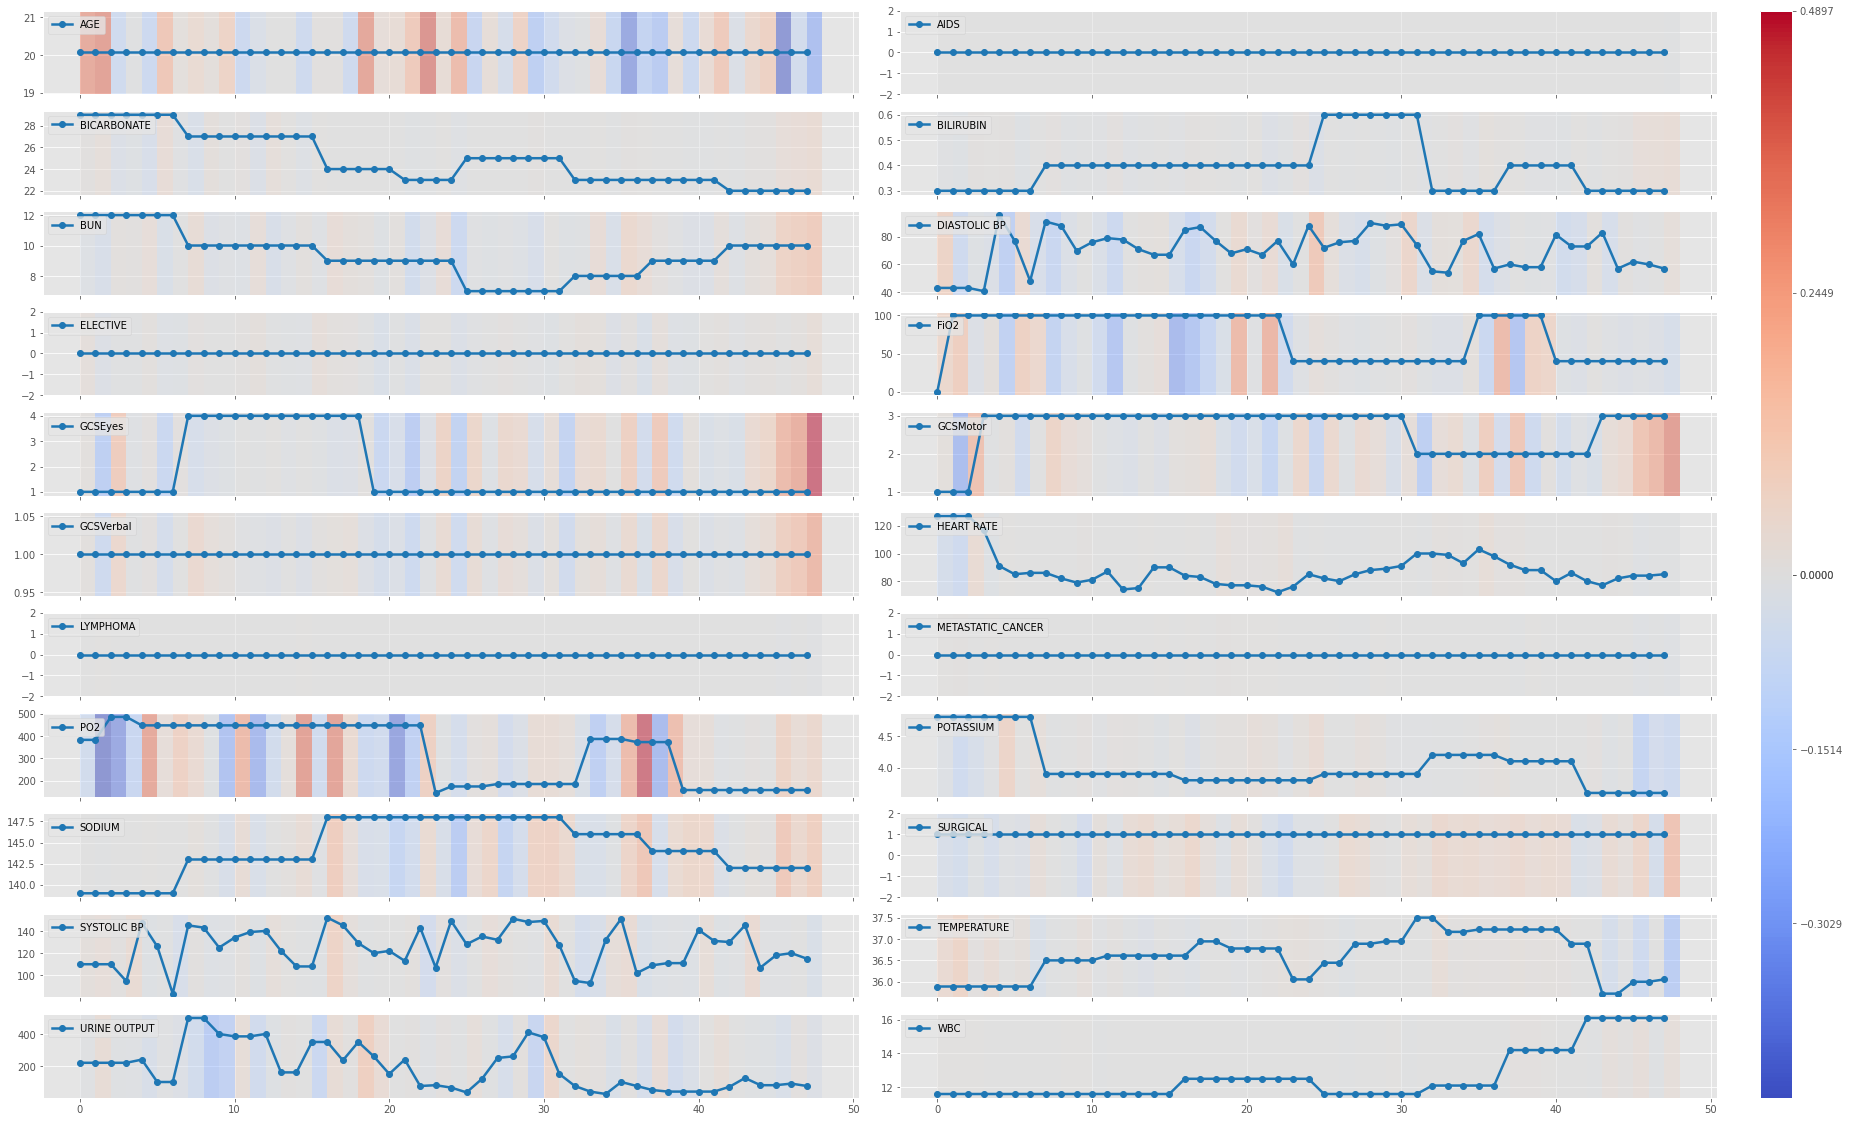

In [ ]:
visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=False, norm=norm, colorbar_ticks=ticks, 
                         feature_importances=heatmap_colors, filename='explain_model_plots/patient{0}_explained_inputs.png'.format(patient_index))

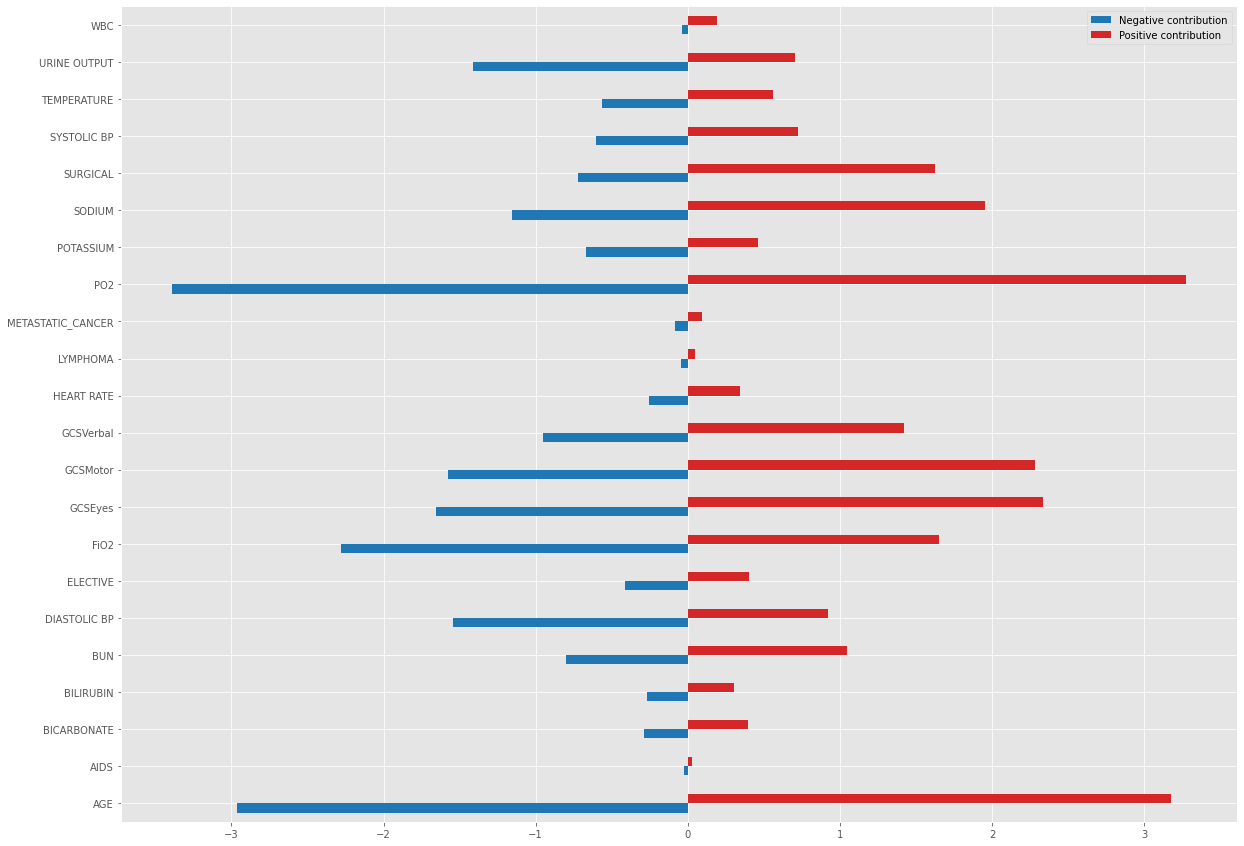

In [ ]:
norm = np.sum(np.abs(scores), axis=1)
positive_contribs = np.sum(scores.clip(min=0), axis=1)
negative_contribs = np.sum(scores.clip(max=0), axis=1)
#plt.figure(figsize = (20,10))
df = pd.DataFrame(index=predictor_names,data={'Negative contribution':negative_contribs, 'Positive contribution':positive_contribs})
'''bars = sns.barplot(x='Predictors', y='Positive contribution', data=df)
for item in bars.get_xticklabels():
    item.set_rotation(45)'''
df.plot.barh(figsize=(20,15), color=[palette(0), palette(3)])
plt.savefig('explain_model_plots/patient{0}_contribs_neg_pos.png'.format(patient_index), dpi=500)

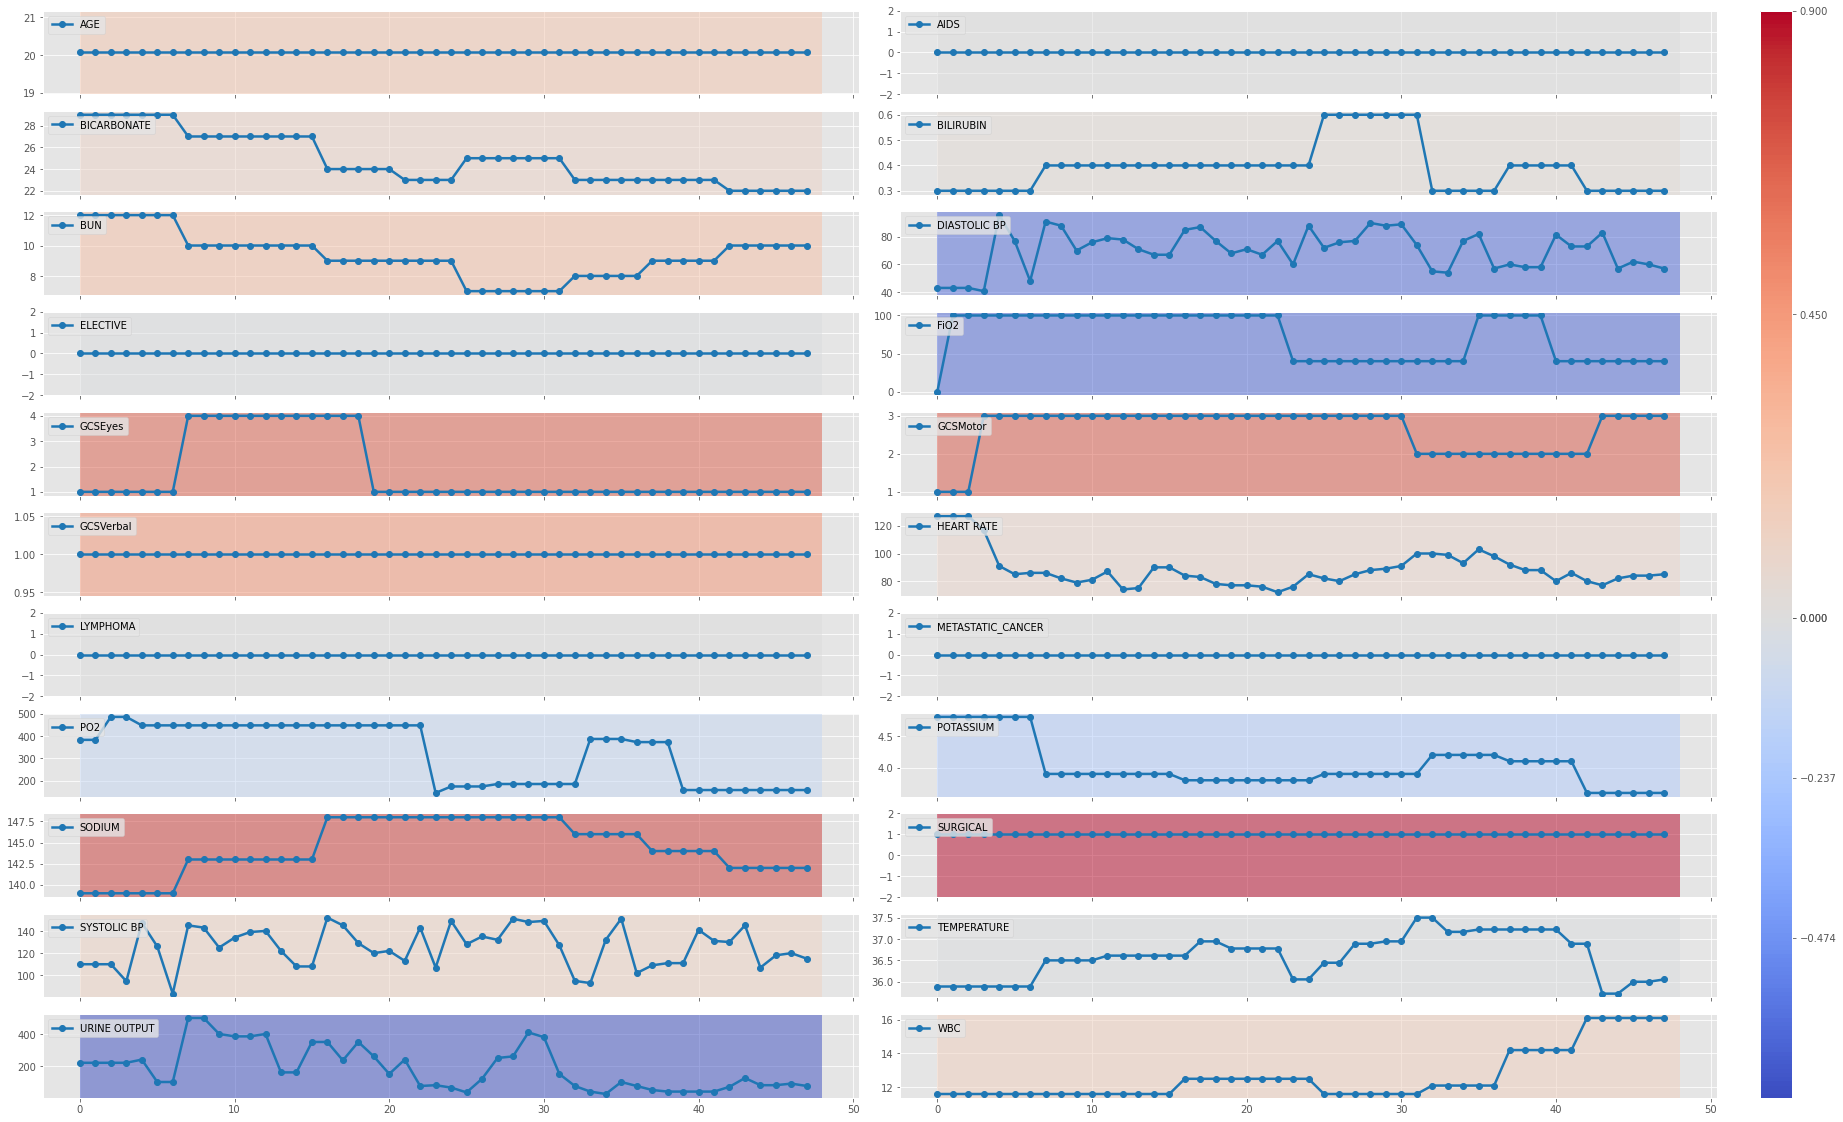

In [ ]:
predictor_scores = np.sum(scores, axis=1)
norm = MidpointNormalize(vmin=predictor_scores.min(), vmax=predictor_scores.max(), midpoint=0)
ticks = np.concatenate((np.linspace(0, predictor_scores.min(), 3, endpoint=False), np.linspace(0, predictor_scores.max(),3)))
predictor_scores = norm(predictor_scores)

heatmap_cm = cm.get_cmap(cmap)

heatmap_colors = heatmap_cm(predictor_scores)

visualize_patient_inputs(patient, 11, 2, size=(30,20), cycle_colors=False, norm=norm, colorbar_ticks=ticks, 
                         feature_importances=heatmap_colors, filename='explain_model_plots/patient{0}_explained_predictors.png'.format(patient_index))

In [ ]:
all_scores = []
for i in range(5):
  print(f'fold {i}')
  importance_func = deeplift_model[i].get_target_contribs_func(
      find_scores_layer_name=input_layer_name, pre_activation_target_layer_name='preact_fc2_0')
  fold_scores = np.array(
      importance_func(task_idx=0, input_data_list=[np.nan_to_num((X[cv_idx[i][1]]- fold_mean[i])/fold_std[i])],
                        input_references_list=[np.zeros_like(X[cv_idx[i][1]])],
                        batch_size=100,progress_update=None))
  all_scores.append(np.squeeze(fold_scores))

fold 0
TARGET LAYER SET TO preact_fc2_0
fold 1
TARGET LAYER SET TO preact_fc2_0
fold 2
TARGET LAYER SET TO preact_fc2_0
fold 3
TARGET LAYER SET TO preact_fc2_0
fold 4
TARGET LAYER SET TO preact_fc2_0


In [ ]:
#all_scores = np.squeeze(all_scores)

all_positive_predictor_scores = []
all_negative_predictor_scores = []
real_outcome = []

for fold_scores, fold_ground_truth in zip(all_scores, ground_truth):
  print(f'number of NaN scores: {np.isnan(fold_scores).sum()/48.}')
  positive_sums = np.sum(fold_scores.clip(min=0), axis=2)
  negative_sums = np.sum(fold_scores.clip(max=0), axis=2)
  for i in range(fold_scores.shape[0]):
    if True:#not np.any(np.isnan(positive_sums[i])) and not np.any(np.isnan(negative_sums[i])):
      all_positive_predictor_scores.append(positive_sums[i]/np.sum(positive_sums[i]))
      all_negative_predictor_scores.append(negative_sums[i]/-np.sum(negative_sums[i]))
      real_outcome.append([fold_ground_truth[i]]*22)
    
all_positive_predictor_scores = np.array(all_positive_predictor_scores).flatten()
all_negative_predictor_scores = np.array(all_negative_predictor_scores).flatten()
all_predictor_names = np.tile(predictor_names,int(all_positive_predictor_scores.shape[0]/22))
real_outcome = np.array(real_outcome).flatten()

df = pd.DataFrame({'Predictors':all_predictor_names,'Positive Importance Score':all_positive_predictor_scores,
                   'Negative Importance Score':all_negative_predictor_scores, 'Real Outcome':real_outcome})

number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0
number of NaN scores: 0.0


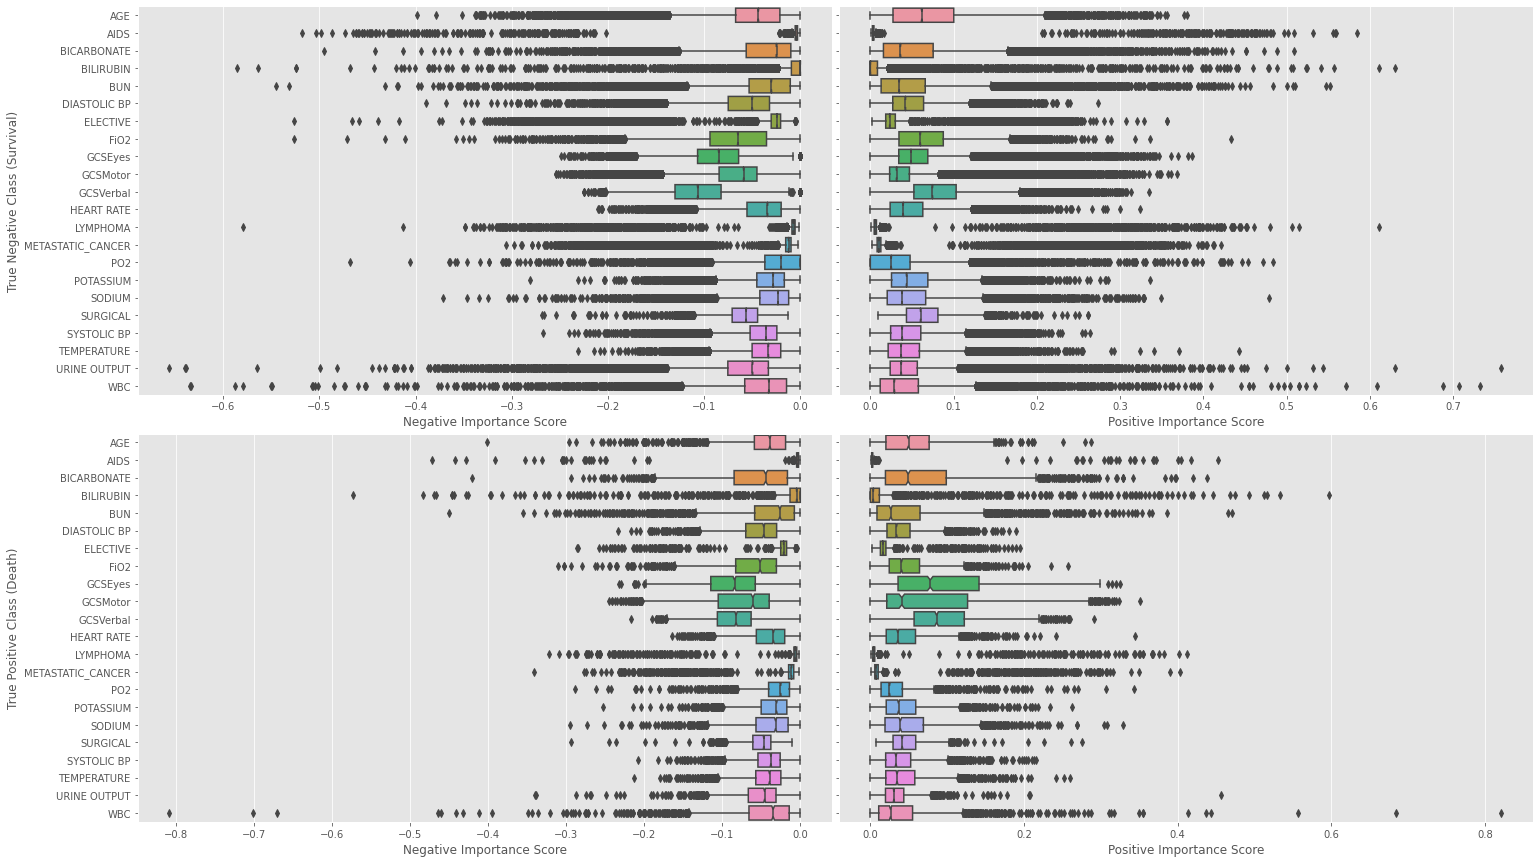

In [ ]:
#plt.figure(figsize=(15,10))
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(25,15))
sns.boxplot( y= "Predictors", x="Negative Importance Score", data=df[df['Real Outcome'] == 0].drop('Real Outcome', axis= 1), notch=True, ax=ax[0,0])
sns.boxplot( y= "Predictors", x="Positive Importance Score", data=df[df['Real Outcome'] == 0].drop('Real Outcome', axis = 1), notch=True, ax=ax[0,1])
sns.boxplot( y= "Predictors", x="Negative Importance Score", data=df[df['Real Outcome'] == 1].drop('Real Outcome', axis= 1), notch=True, ax=ax[1,0])
sns.boxplot( y= "Predictors", x="Positive Importance Score", data=df[df['Real Outcome'] == 1].drop('Real Outcome', axis = 1), notch=True, ax=ax[1,1])
plt.subplots_adjust(wspace=0.01)
plt.subplots_adjust(hspace=0.1)
ax[0,1].set_ylabel('')
ax[1,1].set_ylabel('')
ax[0,0].set_ylabel('True Negative Class (Survival)')
ax[1,0].set_ylabel('True Positive Class (Death)')

plt.savefig('explain_model_plots/dataset_contribs_neg_pos.png', dpi=500)

In [ ]:
#fig, ax = plt.subplots()
grouped = df.groupby('Predictors')
#grouped.median().plot.barh(figsize=(20,15), xerr=grouped.std(), color=[palette(0), palette(3)], ax=ax)
#plt.savefig('explain_model_plots/dataset_contribs_neg_pos.png'.format(patient_index), dpi=500)
grouped.describe()

Positive Importance Score                      ... Real Outcome          
                                      count      mean       std  ...          50%  75%  max
Predictors                                                       ...                       
AGE                                 22413.0  0.066940  0.049919  ...          0.0  0.0  1.0
AIDS                                22413.0  0.007079  0.037382  ...          0.0  0.0  1.0
BICARBONATE                         22413.0  0.056854  0.058620  ...          0.0  0.0  1.0
BILIRUBIN                           22413.0  0.009683  0.035350  ...          0.0  0.0  1.0
BUN                                 22413.0  0.049480  0.054568  ...          0.0  0.0  1.0
DIASTOLIC BP                        22413.0  0.048255  0.030514  ...          0.0  0.0  1.0
ELECTIVE                            22413.0  0.042243  0.052874  ...          0.0  0.0  1.0
FiO2                                22413.0  0.061941  0.036516  ...          0.0  0.0  1.0
GCSEyes                             22413.0  0.064514  0.049834  ...          0.0  0.0  1.0
GCSMotor                            22413.0  0.049495  0.049853  ...          0.0  0.0  1.0
GCSVerbal                           22413.0  0.086117  0.049391  ...          0.0  0.0  1.0
HEART RATE                          22413.0  0.047146  0.032764  ...          0.0  0.0  1.0
LYMPHOMA                            22413.0  0.014039  0.047862  ...          0.0  0.0  1.0
METASTATIC_CANCER                   22413.0  0.023843  0.055997  ...          0.0  0.0  1.0
PO2                                 22413.0  0.032708  0.038512  ...          0.0  0.0  1.0
POTASSIUM                           22413.0  0.050577  0.035170  ...          0.0  0.0  1.0
SODIUM                              22413.0  0.049075  0.040503  ...          0.0  0.0  1.0
SURGICAL                            22413.0  0.062123  0.026169  ...          0.0  0.0  1.0
SYSTOLIC BP                         22413.0  0.045894  0.031296  ...          0.0  0.0  1.0
TEMPERATURE                         22413.0  0.044162  0.032305  ...          0.0  0.0  1.0
URINE OUTPUT                        22413.0  0.046261  0.042060  ...          0.0  0.0  1.0
WBC                                 22413.0  0.041573  0.045089  ...          0.0  0.0  1.0

[22 rows x 24 columns]

In [ ]:
!zip -r /content/explain_plots.zip /content/explain_model_plots
from google.colab import files
files.download("/content/explain_plots.zip")

  adding: content/explain_model_plots/ (stored 0%)
  adding: content/explain_model_plots/patient1_inputs.png (deflated 25%)
  adding: content/explain_model_plots/patient1_explained_predictors.png (deflated 24%)
  adding: content/explain_model_plots/patient1_explained_inputs.png (deflated 18%)
  adding: content/explain_model_plots/patient1_heatmap.png (deflated 39%)
  adding: content/explain_model_plots/patient1_contribs_neg_pos.png (deflated 60%)
  adding: content/explain_model_plots/dataset_contribs_neg_pos.png (deflated 24%)


MessageError: ignored